In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [10]:
keys = Station.__table__.columns.keys()
keys_1 = Measurement.__table__.columns.keys()
print(keys)
print(keys_1)

['id', 'station', 'name', 'latitude', 'longitude', 'elevation']
['id', 'station', 'date', 'prcp', 'tobs']


In [11]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

# Calculate the date 1 year ago from the last data point in the database
last_date = session.query(Measurement.date).order_by(Measurement.date.desc())[0]
last_date


# Perform a query to retrieve the data and precipitation scores
# Sort the dataframe by date
prcp = session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date >= '2016-08-23').order_by(Measurement.date).all()


# Save the query results as a Pandas DataFrame and set the index to the date column
prcp_df = pd.DataFrame(prcp)


Text(0.5, 0, 'date')

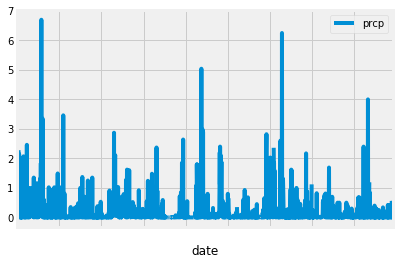

In [12]:
ax = prcp_df.plot()
ax.set_xticklabels(" ")
ax.set_xlabel("date")

In [13]:
# Use Pandas to calcualte the summary statistics for the precipitation data
prcp_df.describe()


,prcp
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [14]:
# Design a query to show how many stations are available in this dataset?
session.query(Station.station).count()

9

In [15]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
temps = session.query(Measurement.station, Measurement.tobs)
t_df = pd.DataFrame(temps)
group = t_df.groupby('station').count().sort_values(by=['tobs'],ascending = False)
group

,tobs
station,
USC00519281,2772
USC00519397,2724
USC00513117,2709
USC00519523,2669
USC00516128,2612
USC00514830,2202
USC00511918,1979
USC00517948,1372
USC00518838,511


In [16]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?

station = session.query(Measurement.station, Measurement.tobs).\
    filter (Measurement.station == 'USC00519281')

station_df = pd.DataFrame(station)
station_df.describe()


,tobs
count,2772.000000
mean,71.663781
std,4.357642
min,54.000000
25%,69.000000
50%,72.000000
75%,74.000000
max,85.000000


In [ ]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

station_1 = session.query(Measurement.station, Measurement.tobs).\
    filter (Measurement.station == 'USC00519281', Measurement.date >= '2016-08-23')

sta_df = pd.DataFrame(station_1)
sta_df['tobs'].plot.hist()


In [17]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [18]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
def calc_temps(start_date, end_date):
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()
temp = calc_temps('2017-06-1', '2017-06-15')
temp

[(72.0, 76.87179487179488, 83.0)]

Text(0, 0.5, 'average temperature')

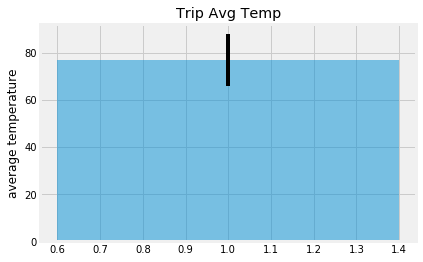

In [19]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
error = 83-72
fig = plt.bar(x = 1, height = 76.87,  yerr=error, align='center', alpha=0.5)

plt.title('Trip Avg Temp')
plt.ylabel('average temperature')



In [86]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation

rain = session.query(Measurement.station, Measurement.prcp).\
    filter(Measurement.date >= '2017-06-01', Measurement.date <= '2017-06-15')
rain_df = pd.DataFrame(rain).groupby('station').sum().sort_values(by=['prcp'],ascending = False)
print(rain_df)


location = session.query(Station.station, Station.name, Station.latitude, Station.longitude, Station.elevation)
location_df = pd.DataFrame(location).groupby('station')
print(location_df)

merge = pd.merge(station, 'name', prcp, 'latitude', 'longitude', 'elevation', on = 'station', how = 'left')


             prcp
station          
USC00516128  5.51
USC00519281  2.98
USC00514830  2.02
USC00513117  1.96
USC00519523  0.76
USC00519397  0.16
USC00517948  0.00


TypeError: merge() got multiple values for argument 'on'

In [74]:
# # data = engine.execute("SELECT * FROM Measurement JOIN Station ON Measurement.station = Station.station")
# df = pd.read_sql_query('SELECT Measurement.prcp, Station.station, Station.name, Station.latitude, Station.longitude, Station.elevation FROM Measurement JOIN Station ON Measurement.station = Station.station',engine)
# print(df.head())
# df.
# df.drop(columns=['name', 'latitude','longitude','elevation']).groupby('station').sum()


   prcp      station                  name  latitude  longitude  elevation
0  0.08  USC00519397  WAIKIKI 717.2, HI US   21.2716  -157.8168        3.0
1  0.00  USC00519397  WAIKIKI 717.2, HI US   21.2716  -157.8168        3.0
2  0.00  USC00519397  WAIKIKI 717.2, HI US   21.2716  -157.8168        3.0
3  0.00  USC00519397  WAIKIKI 717.2, HI US   21.2716  -157.8168        3.0
4   NaN  USC00519397  WAIKIKI 717.2, HI US   21.2716  -157.8168        3.0


,prcp
station,
USC00511918,92.68
USC00513117,382.62
USC00514830,234.49
USC00516128,1068.09
USC00517948,43.44
USC00518838,70.87
USC00519281,588.64
USC00519397,131.62
USC00519523,295.68


## Optional Challenge Assignment

In [ ]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

In [ ]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [ ]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [ ]:
# Plot the daily normals as an area plot with `stacked=False`
